In [1]:
import os
import biom
import warnings
import glob
import numpy as np
import pandas as pd
import itertools
from biom import load_table, Table
import tempfile
from scipy.stats import ttest_ind

import qiime2 as q2
from qiime2 import Artifact
from qiime2 import Metadata
from skbio import OrdinationResults
from skbio import TreeNode
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.qurro.actions import (loading_plot,
                                          differential_plot,
                                          qarcoal)
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.feature_table.actions import filter_samples
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.songbird.actions import multinomial, summarize_paired
warnings.filterwarnings('ignore')

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline


In [2]:
"""

Define some functions to plot with.

"""


def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2, equal_var=True)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    return pairwisedf, max_order


def swarmbox_plot(df, ax, y, x, order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  data=df,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                data=df,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def swarmbox_plot_hue(df, ax, y, x, hue, order,
                      hue_order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  hue = hue,
                  dodge=True,
                  data=df,
                  hue_order=hue_order,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                hue=hue,
                data=df,
                hue_order=hue_order,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True,
                  style_order_ = ['CSseed','Vag','CS']):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 style_order=style_order_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

### 16S cultivation experiment


In [3]:
# metadata
qiita_drop = ['dna_extracted',
              'physical_specimen_remaining',
              'sick']
mf = pd.read_csv('data/16S/vitro/13052_20200307-130432.txt',
                 sep='\t', index_col=0).drop(qiita_drop, axis=1)
mf.index = mf.index.astype(str)
mf = mf[mf.treatment_two.isin(['Etoh-Cultivation'])]
# keep only subject with time (these samples only have one timepoint)
mf = mf[~mf.host_subject_id.isin(['AF41', 'AF42'])]
q2mf = Metadata(mf)
# load tree
q2tree = q2.Artifact.import_data('Phylogeny[Rooted]',
                                 'data/16S/vitro/87350_insertion_tree.relabelled.tre')
tree = q2tree.view(TreeNode)
# load table
bt = load_table('data/16S/vitro/87350_reference-hit.biom')
shared_ = list(set(mf.index) & set(bt.ids()))
bt = bt.filter(shared_)
seqs_ = [node.name for node in tree.tips()]
shared_ = list(set(seqs_) & set(bt.ids('observation')))
bt = bt.filter(shared_ , axis='observation')
q2bt = Artifact.import_data('FeatureTable[Frequency]', bt)
# import taxa
q2tax = q2.Artifact.load('data/16S/vitro/gg-taxonomy.qza')
# view
print(bt.shape)
mf.head(3)


(285, 13)


,alt,altitude,anonymized_name,cage,collection_timestamp,description,elevation,empo_1,empo_2,empo_3,...,physical_specimen_location,qiita_study_id,sample_type,scientific_name,sex,surger_bw,taxon_id,title,treatment_one,treatment_two
sample_name,,,,,,,,,,,,,,,,,,,,,
13052.AF11TP0,unknown,Not applicable,AF11TP0,NaN,2017-05-23 11:35,mouse-ald-gta,193,Host-associated,Animal,Animal distal gut,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation
13052.AF11TP7,unknown,Not applicable,AF11TP7,NaN,2017-05-23 11:36,mouse-ald-gta,193,Host-associated,Animal,Animal distal gut,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation
13052.AF12TP0,unknown,Not applicable,AF12TP0,NaN,2017-05-23 11:37,mouse-ald-gta,193,Host-associated,Animal,Animal distal gut,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation


In [4]:
# run qurro
qartmp = qarcoal(q2bt, q2tax,
                 num_string='p__Bacteroidetes',
                 denom_string='p__Firmicutes').qarcoal_log_ratios
lrdf = pd.concat([qartmp.view(q2.Metadata).to_dataframe(), mf], axis=1)
lrdf.head(3)


,Num_Sum,Denom_Sum,log_ratio,alt,altitude,anonymized_name,cage,collection_timestamp,description,elevation,...,physical_specimen_location,qiita_study_id,sample_type,scientific_name,sex,surger_bw,taxon_id,title,treatment_one,treatment_two
13052.AF11TP0,340.0,467.0,-0.317384,unknown,Not applicable,AF11TP0,NaN,2017-05-23 11:35,mouse-ald-gta,193,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation
13052.AF11TP7,735.0,170.0,1.464072,unknown,Not applicable,AF11TP7,NaN,2017-05-23 11:36,mouse-ald-gta,193,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation
13052.AF12TP0,505.0,1168.0,-0.838490,unknown,Not applicable,AF12TP0,NaN,2017-05-23 11:37,mouse-ald-gta,193,...,UCSDMI,13052,cecum content,mouse gut metagenome,male,unknown,410661,KZALD,Alcohol,Etoh-Cultivation


3.6281416748632136 0.02219639865064604
Cecal Innoculant
2.8851493558179393 0.0343808043002355
Culture


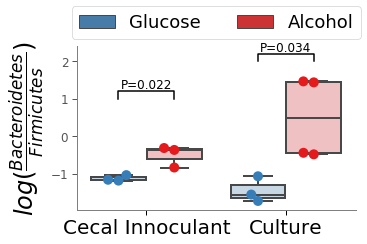

In [5]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1,figsize=(5,3))

order = ['Cecal Innoculant', 'Culture']
lrdf['type'] = lrdf.host_age.replace({0:'Cecal Innoculant',
                                      7:'Culture'})
swarmbox_plot_hue(lrdf, ax, 'log_ratio', 'type',
                  'treatment_one',
                  ['Cecal Innoculant', 'Culture'],
                  ['Glucose', 'Alcohol'],
                  {'Glucose':'#377eb8',
                   'Alcohol':'#e41a1c'})
# relabel
ax.set_ylabel('$log(\\frac{%s}{%s})$' % ('Bacteroidetes',
                                         'Firmicutes') ,
              fontsize=24,
              color='black')

# annotate by order
for i1, c1 in enumerate(order):
    # annot x-axis
    x1, x2 = (i1 -.2), (i1 + .2)
    # get stat
    num_ = lrdf[(lrdf.type == c1) \
                & (lrdf.treatment_one == 'Alcohol')].log_ratio.dropna()
    den_ = lrdf[(lrdf.type == c1) \
                & (lrdf.treatment_one == 'Glucose')].log_ratio.dropna()
    ts_, p_ = ttest_ind(num_, den_)
    print(ts_, p_)
    p_ = 'P=%.3f' % (p_)
    print(c1)
    # heights
    y, h, col = (i1+1), .2, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12)  

# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(-0.05, 1.3),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# save the figure to file
plt.savefig('results/plots/culture-lr-bacter-firm.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [6]:
etoh = pd.read_csv('data/16S/vitro/etoh-hplc.txt', sep='\t').dropna()
etoh_plot = etoh.set_index('Hours').drop(['Timepoint', 'Time difference', 'EC'], axis=1)
etoh_plot = etoh_plot.stack().reset_index()
etoh_plot.columns = ['time','sample_id', 'mM']
etoh_plot['type'] = [v[:-2] if len(v)==4 else v
                     for v in etoh_plot.sample_id]

acetate = pd.read_csv('data/16S/vitro/acetate.txt', sep='\t').dropna()
acetate_plot = acetate.set_index('Hours').drop(['Timepoint', 'Time difference', 'EC'], axis=1)
acetate_plot = acetate_plot.stack().reset_index()
acetate_plot.columns = ['time','sample_id', 'mM']
acetate_plot['type'] = [v[:-2] if len(v)==4 else v
                     for v in acetate_plot.sample_id]

etoh_plot.head(3)


,time,sample_id,mM,type
0,0.0,AF11,34.601967,AF
1,0.0,AF12,48.181157,AF
2,0.0,AF1C,0.229452,AF


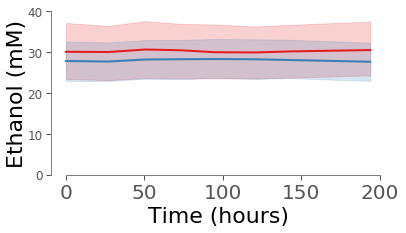

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6, 3))

temporal_plot('time', 'mM', etoh_plot, ax, '',
              'Time (hours)', 'Ethanol (mM)', 
              0, 22, 22, hue='type',
              style=None, size='type',
              min_x = 0, max_x = 200,
              err_style='band', 
              ci=68, cmap='Set1',
              style_order=None,
              dashes_=True,
              style_order_ = ['AF','RF'])
ax.set_ylim(0,40)

""" 
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2,
                         bbox_to_anchor=(.0, 1.35),
                         prop={'size':18},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)
"""

# save the figure to file
plt.savefig('results/plots/culture-etoh.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



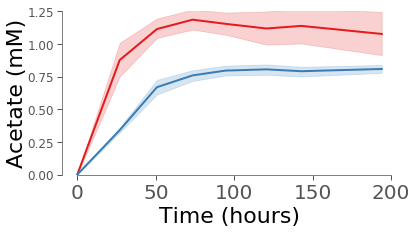

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6, 3))

temporal_plot('time', 'mM', acetate_plot, ax, '',
              'Time (hours)', 'Acetate (mM)', 
              0, 22, 22, hue='type',
              style=None, size='type',
              min_x = 0, max_x = 200,
              err_style='band', 
              ci=68, cmap='Set1',
              style_order=None,
              dashes_=True,
              style_order_ = ['AF','RF'])
ax.set_ylim(0,1.25)

# save the figure to file
plt.savefig('results/plots/culture-acetate.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


### 16S GTA experiment

In [9]:
# import data
q2metdata = q2.Metadata.load('data/16S/vivo/13052_metadata.qza')
q2table = q2.Artifact.load('data/16S/vivo/13052_table.qza')
q2tree = q2.Artifact.load('data/16S/vivo/13052_tree.qza')
q2tax = q2.Artifact.load('data/16S/vivo/13052_taxonomy.qza')
# rare
q2bt_filt = rarefy(q2table, 1500).rarefied_table
# run deicode
rpca_res = rpca(q2bt_filt, n_components=2,
                min_feature_count=8,
                min_feature_frequency=10)
# pairwise PERMANOVA
perm_res = beta_group_significance(rpca_res.distance_matrix,
                                   q2metdata.get_column('treatment'),
                                   pairwise=True, permutations=1000)
# save all intermediate files into tmp dir
with tempfile.TemporaryDirectory() as temp_dir_name:
    perm_res.visualization.export_data(temp_dir_name)
    pairwisedf = pd.read_csv(os.path.join(temp_dir_name,
                                          'permanova-pairwise.csv'))

# distances to plot    
mf = q2metdata.to_dataframe()
distdf = rpca_res.distance_matrix.view(DistanceMatrix).to_data_frame()
distdf = distdf[mf[mf.treatment == 'Alcohol-GTA'].index].stack().reset_index()
map_treat = dict(mf['treatment'])
distdf['treatment'] = [map_treat[x] for x in distdf['level_0']]
distdf['dist'] = distdf[0]


<Figure size 432x288 with 0 Axes>

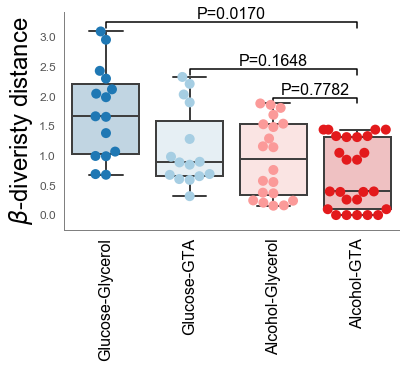

In [10]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 12

fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
order = ['Glucose-Glycerol','Glucose-GTA',
         'Alcohol-Glycerol','Alcohol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Alcohol-Glycerol':'#fb9a99',
         'Alcohol-GTA':'#e31a1c'}

ax = swarmbox_plot(distdf, ax,
                   'dist',
                   'treatment',
                   order,
                   palette=pallette)

# annotate by order
i1 = 2
c1 = order[::-1][0]
for i2, c2 in enumerate(order[::-1][1:]):
    # annot x-axis
    x1, x2 = 2-i2, (i1 + 1)
    # get stat
    p_ = pairwisedf[(pairwisedf['Group 1'] == 'Alcohol-GTA') \
                    & (pairwisedf['Group 2'] == c2)]['p-value']
    p_ = 'P=%.4f' % (p_)
    # heights
    y, h, col = distdf[distdf.treatment.isin([c2])][0].max() + .3 * ((i2*.1)), .1, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=16)  

    
# relabel
ax.set_ylabel('$\\beta$-diveristy distance',
              fontsize=24,
              color='black')
ax.tick_params(axis='x', rotation=90)

# save the figure to file
plt.savefig('results/plots/GTA-treatment-distance.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

In [13]:
epochs = 3000
batch_size = 6
num_random_test_examples = 5
differential_prior = 1.5
learning_rate = 0.001
min_feature_count = 1

songbird_model = multinomial(q2table, q2metdata,
                             'C(treatment, Treatment("Glucose-Glycerol"))',
                             summary_interval=.001,
                             epochs = epochs,
                             num_random_test_examples=num_random_test_examples,
                             batch_size = batch_size,
                             differential_prior = differential_prior,
                             learning_rate = learning_rate,
                             min_feature_count = min_feature_count,
                             random_seed=0)
songbird_baseline = multinomial(q2table, q2metdata,
                                "1",
                                summary_interval=.001,
                                 epochs = epochs,
                                 batch_size = batch_size,
                                num_random_test_examples=num_random_test_examples,
                                 differential_prior = differential_prior,
                                 learning_rate = learning_rate,
                                 min_feature_count = min_feature_count,
                                 random_seed=0)

100%|██████████| 3000/3000 [00:06<00:00, 462.33it/s]


<visualization: Visualization uuid: 4c74151e-1f5a-4d57-be0f-def6c303aebe>

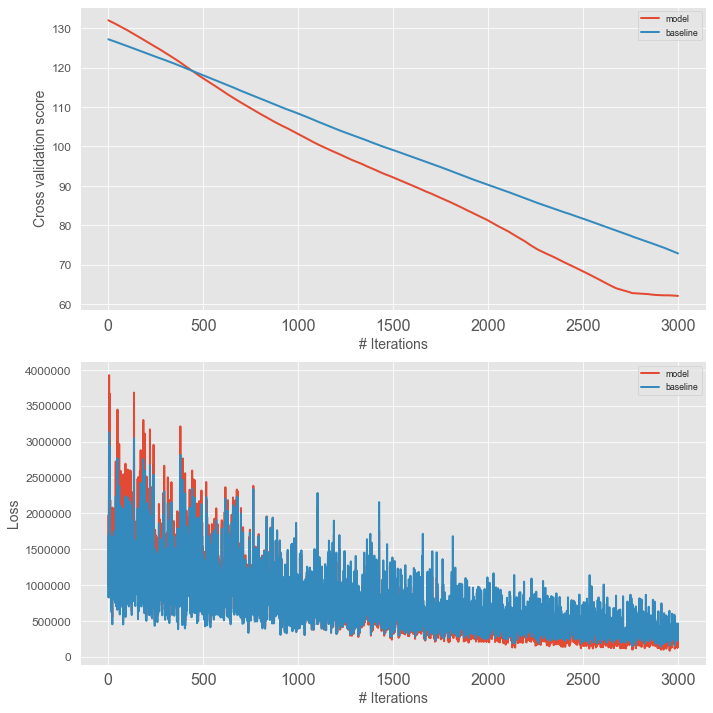

In [14]:
model_summary = summarize_paired(songbird_model.regression_stats,
                                 songbird_baseline.regression_stats)
model_summary.visualization


In [17]:
diffdf = songbird_model.differentials.view(q2.Metadata).to_dataframe()
taxdf = q2tax.view(q2.Metadata).to_dataframe()
diffdf = pd.concat([diffdf, taxdf], axis=1).dropna(0)
diffdf = diffdf.sort_values('C(treatment, Treatment("Glucose-Glycerol"))[T.Glucose-GTA]')
num = (diffdf['C(treatment, Treatment("Glucose-Glycerol"))[T.Glucose-GTA]'] > 0.0).values\
       & (diffdf.Taxon.str.contains("p__Bacteroidetes")).values
denom = (diffdf['C(treatment, Treatment("Glucose-Glycerol"))[T.Glucose-GTA]'] < 0.0).values\
        & (diffdf.Taxon.str.contains("p__Proteobacteria")).values

num = diffdf.index[num]
denom = diffdf.index[denom]
bt = q2table.view(Table)
btdf = pd.DataFrame(bt.matrix_data.toarray() + 1,
                    bt.ids('observation'), bt.ids())
btdf = btdf.loc[btdf.astype(bool).sum(1) / btdf.shape[1] > .0,:]

lr = np.log(btdf.loc[num, :].sum()) - np.log(btdf.loc[denom, :].sum())
lr[~np.isfinite(lr)] = np.nan
lr = pd.DataFrame(lr, columns=['log_ratio'])
tot_ = pd.DataFrame(bt.sum('sample'),bt.ids(),['total_coutns'])
lrdf = pd.concat([lr, q2metdata.to_dataframe(), tot_], axis=1).dropna(subset=['log_ratio'])
lrdf.head(3)


,log_ratio,alt,altitude,anonymized_name,cage,collection_timestamp,description,elevation,empo_1,empo_2,...,sample_type,scientific_name,sex,surger_bw,taxon_id,title,treatment_one,treatment_two,treatment,total_coutns
13052.5499,5.917357,73.814,Not applicable,5499.0,cage-1,2017-05-23 11:00,mouse-ald-gta,193.0,Host-associated,Animal,...,cecum content,mouse gut metagenome,male,26.0,410661.0,KZALD,Alcohol,GTA,Alcohol-GTA,63478.0
13052.5500,5.836480,54.651,Not applicable,5500.0,cage-1,2017-05-23 11:01,mouse-ald-gta,193.0,Host-associated,Animal,...,cecum content,mouse gut metagenome,male,25.0,410661.0,KZALD,Alcohol,GTA,Alcohol-GTA,11696.0
13052.5501,7.635223,62.120,Not applicable,5501.0,cage-1,2017-05-23 11:02,mouse-ald-gta,193.0,Host-associated,Animal,...,cecum content,mouse gut metagenome,male,25.7,410661.0,KZALD,Alcohol,GTA,Alcohol-GTA,41900.0


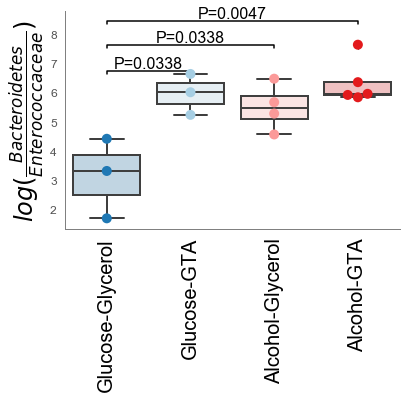

In [19]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


lrdf = lrdf[lrdf['cage'] == 'cage-1']

fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
order = ['Glucose-Glycerol','Glucose-GTA',
         'Alcohol-Glycerol','Alcohol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Alcohol-Glycerol':'#fb9a99',
         'Alcohol-GTA':'#e31a1c'}

ax = swarmbox_plot(lrdf, ax,
                   'log_ratio',
                   'treatment',
                   order,
                   palette=pallette)
# get stats
combo = [('Glucose-Glycerol','Controls + No-PMA'),
         ('Glucose-Glycerol','Rooms + PMA'),
         ('Glucose-Glycerol','Controls + PMA')]
statdf, max_order = pairwise_ttest(lrdf,
                                   'treatment',
                                   'log_ratio',
                                   correction=False)

# annotate by order
i1 = 0 
c1 = order[0]
size_ = [1.1,1.5,.5]
for i2, c2 in enumerate(order[1:]):
    # annot x-axis
    x1, x2 = i1, (i2 + 1)
    # get label
    label_ = c1 + ' vs. ' + c2
    if label_ not in statdf.index:
        label_ = c2 + ' vs. ' + c1
    # get stat
    p_ = statdf.loc[label_, 'P']
    p_ = 'P=%.4f' % (p_)
    # heights
    y, h, col = max_order[label_] + .7 * ((i2*size_[i2])), .1, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=16)  

    
# relabel
ax.set_ylabel('$log(\\frac{%s}{%s})$' % ('Bacteroidetes',
                                         'Enterococcaceae') ,
              fontsize=24,
              color='black')
#ax.tick_params(axis='x', rotation=90)
#ax.tick_params(axis='y', rotation=90)
ax.tick_params(axis='x', rotation=90)
    
# save the figure to file
plt.savefig('results/plots/GTA-treatment-lr.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()